#### Importing Dataset

In [1]:
import numpy as np
import pandas as pd

calendar_df = pd.read_csv('E:/Documents/TanXor/Dataset/calendar.csv')
sales_df = pd.read_csv('E:/Documents/TanXor/Dataset/sales_train_validation.csv')

#### Data Aggregation

In [8]:
sales_df['d_id'] = sales_df['store_id'] + '_' + sales_df['dept_id']

sales_df = sales_df.drop(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], axis=1)

sales_df = sales_df.groupby('d_id').sum()

sales_df = sales_df.T

sales_df['d'] = sales_df.index

df = sales_df.merge(calendar_df, how = 'outer')

df = df.drop(['wm_yr_wk', 'weekday', 'wday', 'month', 'year', 'd',
       'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2',
       'snap_CA', 'snap_TX', 'snap_WI'], axis=1)

df['date']=pd.to_datetime(df['date'])

df.set_index('date',inplace=True)

df = df.dropna()

d_id,CA_1_FOODS_1,CA_1_FOODS_2,CA_1_FOODS_3,CA_1_HOBBIES_1,CA_1_HOBBIES_2,CA_1_HOUSEHOLD_1,CA_1_HOUSEHOLD_2,CA_2_FOODS_1,CA_2_FOODS_2,CA_2_FOODS_3,...,WI_2_HOBBIES_2,WI_2_HOUSEHOLD_1,WI_2_HOUSEHOLD_2,WI_3_FOODS_1,WI_3_FOODS_2,WI_3_FOODS_3,WI_3_HOBBIES_1,WI_3_HOBBIES_2,WI_3_HOUSEHOLD_1,WI_3_HOUSEHOLD_2
d_1,297,674,2268,528,28,361,181,406,212,1575,...,10,353,98,152,583,2293,256,22,584,148
d_2,284,655,2198,489,9,350,170,408,227,1286,...,7,268,94,138,585,2383,342,14,541,195
d_3,214,396,1398,409,6,279,114,238,138,913,...,18,250,69,127,575,1841,228,20,420,106
d_4,175,476,1607,383,9,278,123,240,174,1126,...,15,305,80,98,533,1965,183,11,327,94
d_5,182,354,1496,263,5,195,135,220,102,956,...,1,118,32,87,340,1427,70,4,151,53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
d_1909,287,423,1780,333,30,665,204,422,450,1634,...,26,800,113,180,473,1579,202,42,535,148
d_1910,297,365,1871,380,30,580,186,334,349,1578,...,25,907,127,227,411,1670,182,21,573,142
d_1911,331,489,2140,471,56,695,205,579,396,1896,...,37,1106,160,261,507,1897,264,32,701,166
d_1912,419,590,2646,621,49,933,319,623,620,2517,...,25,1177,194,324,505,2411,381,32,801,232


### Visualizing the Data

In [12]:
df_1 = df[['CA_1_FOODS_1']].copy()

df_1.rename(columns = {'CA_1_FOODS_1':'Sales'}, inplace = True)

df_1.index = df.index

df_1['Sales'].iloc[:30].plot(figsize=(15, 5))

,Sales
date,
2011-01-29,297.0
2011-01-30,284.0
2011-01-31,214.0
2011-02-01,175.0
2011-02-02,182.0


In [13]:
%pip install statsmodels

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [14]:
### Testing For Stationarity

from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [15]:
def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

adfuller_test(df_1['Sales'])

### Feature Engineering

In [17]:
df_1['Sales_shifted'] = df_1['Sales'].shift(7)  # Shifting (Lag)

df_1['adj_log'] = np.log(df_1['Sales'])   # LogTransformation

df_1['Seasonal_Differnce'] = df_1['Sales'] - df_1['Sales_shifted']  # Differencing

df_1['Seasonal_Differnce'].plot()

adfuller_test(df_1['Seasonal_Differnce'].dropna())

,Sales,Sales_shifted
date,,
2011-01-29,297.0,NaN
2011-01-30,284.0,NaN
2011-01-31,214.0,NaN
2011-02-01,175.0,NaN
2011-02-02,182.0,NaN


### Model Training

In [27]:
model=sm.tsa.statespace.SARIMAX(df_1['Sales'],order=(1, 1, 1),seasonal_order=(1,1,1,7))
results=model.fit()

c:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


<AxesSubplot:xlabel='date'>

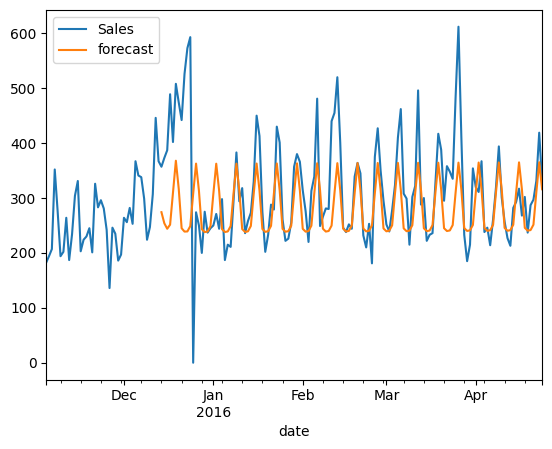

In [28]:
df_1['forecast']=results.predict(start=1780,end=1913,dynamic=True)
df_1[['Sales','forecast']].iloc[1740:].plot()

### Hyperparamter Tuning

In [29]:
import warnings
from statsmodels.tools.sm_exceptions import ValueWarning

# Ignore ValueWarning from statsmodels
warnings.simplefilter('ignore', ValueWarning)

In [30]:
### Import Packages ###
'''
import itertools

### Define Parameter Ranges to Test ###

# Note: higher numbers will result in code taking much longer to run
# Here we have it set to test p,d,q each = 0, 1 & 2

# Define the p, d and q parameters to take any value between 0 and 3 (exclusive)
p = range(1, 6)
q = range(0, 6)
d = range(1, 2)
P = range(0, 4)
Q = range(0, 4)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
# Note: here we have 12 in the 's' position as we have monthly data
# You'll want to change this according to your time series' frequency
pdqs = [(x[0], x[1], x[2], 7) for x in list(itertools.product(P, d, Q))]

### Run Grid Search ###

# Note: this code will take a while to run

# Define function
def sarimax_gridsearch(ts, pdq, pdqs, freq='D'):
    
    Input: 
        ts : your time series data
        pdq : ARIMA combinations from above
        pdqs : seasonal ARIMA combinations from above
        maxiter : number of iterations, increase if your model isn't converging
        frequency : default='M' for month. Change to suit your time series frequency
            e.g. 'D' for day, 'H' for hour, 'Y' for year. 
        
    Return:
        Prints out top 5 parameter combinations
        Returns dataframe of parameter combinations ranked by BIC
    

    # Run a grid search with pdq and seasonal pdq parameters and get the best BIC value
    ans = []
    for comb in pdq:
        for combs in pdqs:
            try:
                mod = sm.tsa.statespace.SARIMAX(ts, # this is your time series you will input
                                                order=comb,
                                                seasonal_order=combs,
                                                enforce_stationarity=False, 
                                                enforce_invertibility=False,
                                                freq=freq)

                output = mod.fit(maxiter=1000)
                predictions = output.predict(start=1800,end=1913,dynamic=True)

                test_data = ts.iloc[1800:1913]
                mape = np.mean(np.abs((test_data - predictions) / test_data)) * 100

                ans.append([comb, combs, output.bic, mape])
                print('SARIMAX {} x {}12 : MAPE Calculated ={}'.format(comb, combs, mape))
            except:
                continue
            
    # Find the parameters with minimal BIC value

    # Convert into dataframe
    ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'bic', 'mape'])

    # Sort and return top 5 combinations
    ans_df = ans_df.sort_values(by=['mape'],ascending=True)
    
    return ans_df
    
'''

"\nimport itertools\nimport statsmodels.api as sm\n\n### Define Parameter Ranges to Test ###\n\n# Note: higher numbers will result in code taking much longer to run\n# Here we have it set to test p,d,q each = 0, 1 & 2\n\n# Define the p, d and q parameters to take any value between 0 and 3 (exclusive)\np = range(1, 6)\nq = range(0, 6)\nd = range(1, 2)\nP = range(0, 4)\nQ = range(0, 4)\n\n# Generate all different combinations of p, q and q triplets\npdq = list(itertools.product(p, d, q))\n\n# Generate all different combinations of seasonal p, q and q triplets\n# Note: here we have 12 in the 's' position as we have monthly data\n# You'll want to change this according to your time series' frequency\npdqs = [(x[0], x[1], x[2], 7) for x in list(itertools.product(P, d, Q))]\n\n### Run Grid Search ###\n\n# Note: this code will take a while to run\n\n# Define function\ndef sarimax_gridsearch(ts, pdq, pdqs, freq='D'):\n    \n    Input: \n        ts : your time series data\n        pdq : ARIMA co

In [31]:
### Apply function to your time series data ###

# Remember to change frequency to match your time series data
# best_params = sarimax_gridsearch(df_1['Sales'], pdq, pdqs, freq='D')

In [32]:
# best_params.head(20)

c:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                      SARIMAX Results                                      
Dep. Variable:                               Sales   No. Observations:                 1913
Model:             SARIMAX(3, 1, 3)x(0, 1, [1], 7)   Log Likelihood              -10462.570
Date:                             Thu, 03 Aug 2023   AIC                          20941.139
Time:                                     13:57:12   BIC                          20985.511
Sample:                                 01-29-2011   HQIC                         20957.476
                                      - 04-24-2016                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -2.0533      0.069    -29.792      0.000      -2.188      -1.918
ar.L2         -1.1877      

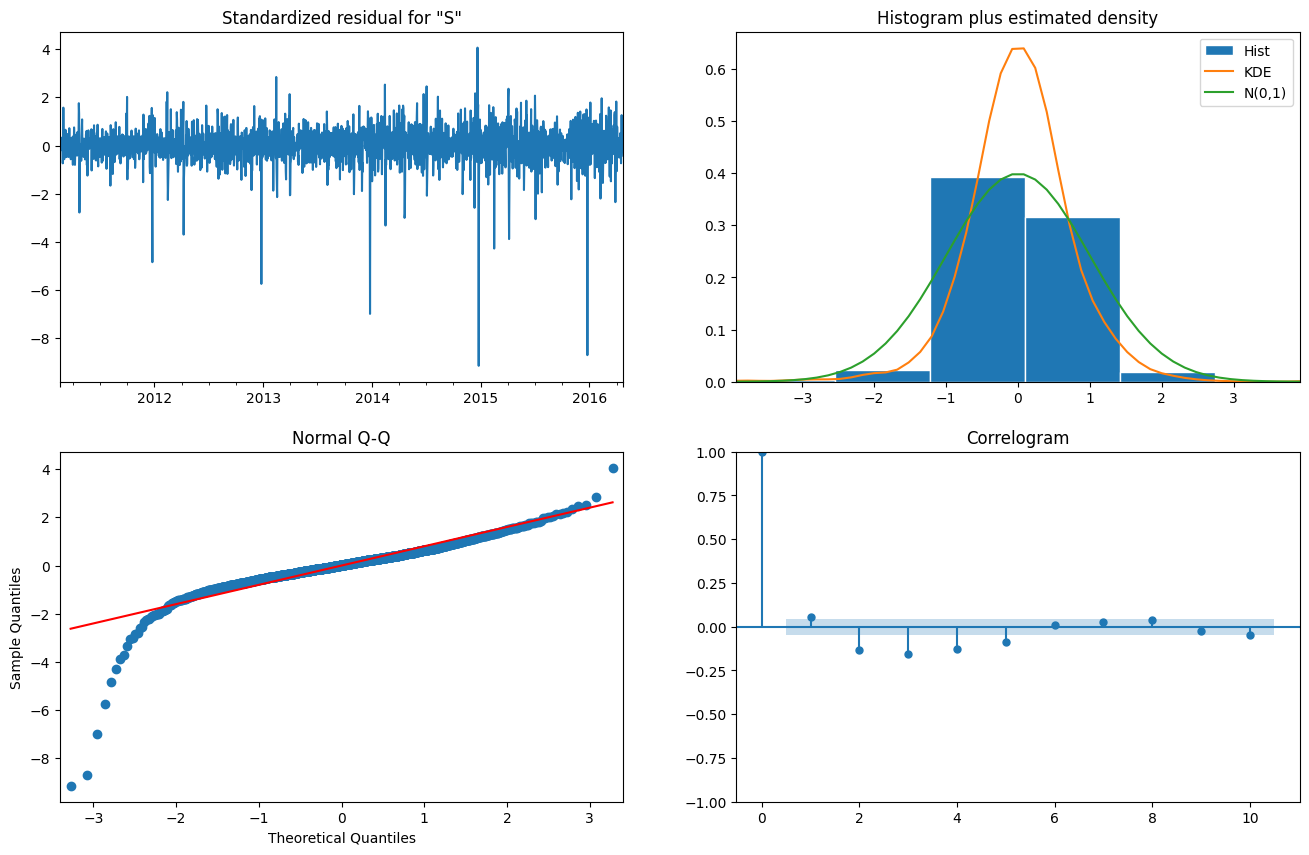

In [33]:
# Build SARIMAX model w/optimal parameters
sarimax = sm.tsa.statespace.SARIMAX(df_1['Sales'], 
                                    order=(3,1,3), 
                                    seasonal_order=(0,1,1,7), 
                                    enforce_stationarity=False, 
                                    enforce_invertibility=False,
                                    freq='D')
                                    
# Fit the model
output = sarimax.fit()
    
# Print output summary
print(output.summary())

# Plot diagnostics
output.plot_diagnostics(figsize=(16,10));

<AxesSubplot:xlabel='date'>

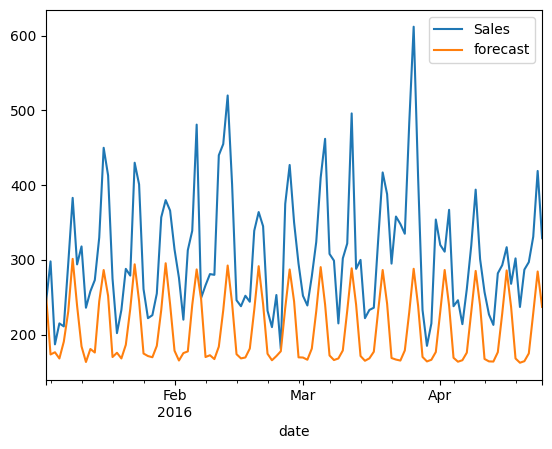

In [34]:
df_1['forecast']=output.predict(start=1800,end=1913,dynamic=True)
df_1[['Sales','forecast']].iloc[1800:].plot()

In [35]:
%pip install optuna


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip



                                              0.0/390.6 kB ? eta -:--:--
     ---                                      30.7/390.6 kB ? eta -:--:--
     ---                                   41.0/390.6 kB 393.8 kB/s eta 0:00:01
     ------                                71.7/390.6 kB 491.5 kB/s eta 0:00:01
     ----------                           112.6/390.6 kB 598.8 kB/s eta 0:00:01
     -----------                          122.9/390.6 kB 554.9 kB/s eta 0:00:01
     --------------------                 225.3/390.6 kB 765.3 kB/s eta 0:00:01
     -----------------------              256.0/390.6 kB 749.3 kB/s eta 0:00:01
     --------------------------           286.7/390.6 kB 708.9 kB/s eta 0:00:01
     ---------------------------------    368.6/390.6 kB 820.1 kB/s eta 0:00:01
     ------------------------------------ 390.6/390.6 kB 812.7 kB/s eta 0:00:00
                                              0.0/224.5 kB ? eta -:--:--
     ------------------------------------- 224.5/224.5 kB 1

In [42]:
import optuna
from sklearn.model_selection import cross_val_score
#from sklearn import datasets

def objective(trial):
    p = trial.suggest_int('p', 0, 6)
    # d = trial.suggest_int('d', 1, 3)
    q = trial.suggest_int('q', 0, 6)
    P = trial.suggest_int('P', 0, 6)
    Q = trial.suggest_int('Q', 0, 6)
    # m = trial.suggest_int('m', 3, 8)
    srx = sm.tsa.statespace.SARIMAX(df_1['Sales'], 
                                    order=(p,1,q), 
                                    seasonal_order=(P,1,Q,7), 
                                    enforce_stationarity=False, 
                                    enforce_invertibility=False,
                                    freq='D')
    
    output = srx.fit(maxiter=1000)
    predictions = output.predict(start=1800,end=1913,dynamic=True)

    test_data = df_1['Sales'].iloc[1800:1913]
    mape = np.mean(np.abs((test_data - predictions) / test_data)) * 100

    return mape

In [43]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

[I 2023-08-03 14:13:44,980] A new study created in memory with name: no-name-d3a88e2d-70c2-4299-ac37-ded2f1338b2c


[I 2023-08-03 14:15:03,353] Trial 0 finished with value: 35.36506206278672 and parameters: {'p': 2, 'q': 3, 'P': 2, 'Q': 3}. Best is trial 0 with value: 35.36506206278672.
[I 2023-08-03 14:16:30,499] Trial 1 finished with value: 13.566051763840193 and parameters: {'p': 2, 'q': 1, 'P': 0, 'Q': 6}. Best is trial 1 with value: 13.566051763840193.
[I 2023-08-03 14:17:23,963] Trial 2 finished with value: 13.443581957988687 and parameters: {'p': 5, 'q': 2, 'P': 1, 'Q': 2}. Best is trial 2 with value: 13.443581957988687.
[I 2023-08-03 14:22:10,481] Trial 3 finished with value: 13.268217980441523 and parameters: {'p': 2, 'q': 4, 'P': 5, 'Q': 3}. Best is trial 3 with value: 13.268217980441523.
[I 2023-08-03 14:26:45,525] Trial 4 finished with value: 34.92832687890298 and parameters: {'p': 3, 'q': 3, 'P': 5, 'Q': 1}. Best is trial 3 with value: 13.268217980441523.
[I 2023-08-03 14:26:57,331] Trial 5 finished with value: 21.527837123181147 and parameters: {'p': 3, 'q': 3, 'P': 0, 'Q': 0}. Best is

KeyboardInterrupt: 

In [ ]:
trial = study.best_trial
print('Mape: {}'.format(trial.value))

In [ ]:
print("Best hyperparameters: {}".format(trial.params))